<h3 style = "font-size:40px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049; text-align: center; border-radius: 5px 5px; padding: 5px">Train, Deploy and Update a HuggingFace BERT model on Disaster Tweets Classification dataset using AWS SageMaker </h3>

NLP techniques such as [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), [word2vec](https://en.wikipedia.org/wiki/Word2vec), or [bag-of-words (BOW)](https://en.wikipedia.org/wiki/Bag-of-words_model) used to generate word embeddings features which can be used for training text classification models. They have been very successful in many NLP tasks but they don’t always capture the meanings of words accurately when they appear in different contexts.

We achieved the better results in text classification tasks with the help of [BERT](https://arxiv.org/abs/1810.04805) because of its ability more accurately encode the meaning of words in different contexts.

[Amazon SageMaker](https://docs.aws.amazon.com/sagemaker/index.html) enables developers to create, train, deploy and monitor machine-learning models in the cloud.

In this example, we walk through our dataset, the training process, and finally model deployment.

<a id = '0'></a>
<h2 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #007580; color : #fed049; border-radius: 5px 5px; text-align:center; font-weight: bold" >Table of Contents</h2> 

1. [Problem Statement](#1.0)
2. [Setup](#2.0)
3. [Data Preparation](#3.0)
4. [EDA](#4.0)
5. [Amazon SageMaker Training](#5.0)
6. [Train on Amazon SageMaker using on-demand instances with Epoch=2](#6.0)
7. [Train on Amazon SageMaker using spot instances](#7.0)
8. [Host the model on an Amazon SageMaker Endpoint](#8.0)
9. [Train on Amazon SageMaker using on-demand instances with Epoch=3](#9.0)
10. [Update a SageMaker model endpoint](#10.0)
11. [Clean up](#11.0)
12. [Conclusion and references](#11.0)

<a id = '1.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 1. Problem Statement </h2>

Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programmatically monitoring Twitter (i.e. disaster relief organizations and news agencies). However, identifying such tweets has always been a difficult task because of the ambiguity in the linguistic structure of the tweets and hence it is not always clear whether an individual’s words are actually announcing a disaster.

More details [here](https://www.kaggle.com/c/nlp-getting-started/overview)

<a id = '2.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 2. Setup </h2>

To start, we import some Python libraries and initialize a SageMaker session, S3 bucket and prefix, and IAM role.

In [3]:
import os
import numpy as np
import pandas as pd
import sagemaker

sagemaker_session = sagemaker.Session()    # Provides a collection of methods for working with SageMaker resources

bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/DEMO-huggingface-bert"
region = sagemaker_session.boto_session.region_name
role = sagemaker.get_execution_role()      # Get the execution role for the notebook instance. 
                                           # This is the IAM role that we created for our notebook instance. 
                                           # We pass the role to the tuning job(later on).

In [4]:
# used to supress display of warnings
import warnings

# suppress display of warnings
warnings.filterwarnings('ignore')

<a id = '3.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 3. Data Preparation </h2>

Kaggle hosted a challenge named `Real` or `Not` whose aim was to use the Twitter data of disaster tweets, originally created by the company figure-eight, to classify Tweets talking about `real disaster` against the ones talking about it metaphorically. (https://www.kaggle.com/c/nlp-getting-started/overview)

### Get `sentences` and `labels`

Let us take a quick look at our data and for that we need to first read the training data. 
The only two columns we interested are:

- the `sentence` (the tweet)
- the `label`    (the label, this denotes whether a tweet is about a real disaster (1) or not (0))

In [5]:
df = pd.read_csv(
    "dataset/raw/data.csv",
    header=None,
    usecols=[1, 3],
    names=["label", "sentence"],
)


sentences = df.sentence.values
labels = df.label.values

In [6]:
df.head()

,label,sentence
0,1,Our Deeds are the Reason of this #earthquake M...
1,1,Forest fire near La Ronge Sask. Canada
2,1,All residents asked to 'shelter in place' are ...
3,1,"13,000 people receive #wildfires evacuation or..."
4,1,Just got sent this photo from Ruby #Alaska as ...


Printing few tweets with its class label 

In [7]:
list(zip(sentences[80:85], labels[80:85]))

[("mom: 'we didn't get home as fast as we wished' \nme: 'why is that?'\nmom: 'there was an accident and some truck spilt mayonnaise all over ??????",
  0),
 ("I was in a horrible car accident this past Sunday. I'm finally able to get around. Thank you GOD??",
  1),
 ('Can wait to see how pissed Donnie is when I tell him I was in ANOTHER accident??',
  0),
 ("#TruckCrash Overturns On #FortWorth Interstate http://t.co/Rs22LJ4qFp Click here if you've been in a crash&gt;http://t.co/Ld0unIYw4k",
  1),
 ('Accident in #Ashville on US 23 SB before SR 752 #traffic http://t.co/hylMo0WgFI',
  1)]

### Cleaning Text


As we can see from the above output, there are few information which are not that important, like `URLs`, `Emojis`, `Tags`, etc. So, now lets try to clean the dataset before we actually pass this data for training. 

In [8]:
import string
import re

In [9]:
# Helper functions to clean text by removing urls, emojis, html tags and punctuations.

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)



In [10]:
df['sentence'] = df['sentence'].apply(lambda x: remove_URL(x))
df['sentence'] = df['sentence'].apply(lambda x: remove_emoji(x))
df['sentence'] = df['sentence'].apply(lambda x: remove_html(x))
df['sentence'] = df['sentence'].apply(lambda x: remove_punct(x))

In [11]:
df.head()

,label,sentence
0,1,Our Deeds are the Reason of this earthquake Ma...
1,1,Forest fire near La Ronge Sask Canada
2,1,All residents asked to shelter in place are be...
3,1,13000 people receive wildfires evacuation orde...
4,1,Just got sent this photo from Ruby Alaska as s...


In [12]:
sentences = df.sentence.values
labels = df.label.values

In [13]:
list(zip(sentences[80:85], labels[80:85]))

[('mom we didnt get home as fast as we wished \nme why is that\nmom there was an accident and some truck spilt mayonnaise all over ',
  0),
 ('I was in a horrible car accident this past Sunday Im finally able to get around Thank you GOD',
  1),
 ('Can wait to see how pissed Donnie is when I tell him I was in ANOTHER accident',
  0),
 ('TruckCrash Overturns On FortWorth Interstate  Click here if youve been in a crash',
  1),
 ('Accident in Ashville on US 23 SB before SR 752 traffic ', 1)]

<a id = '4.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 4. EDA </h2>

Let's spend couple of minutes to explore the dataset

## a) Data Distribution 

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

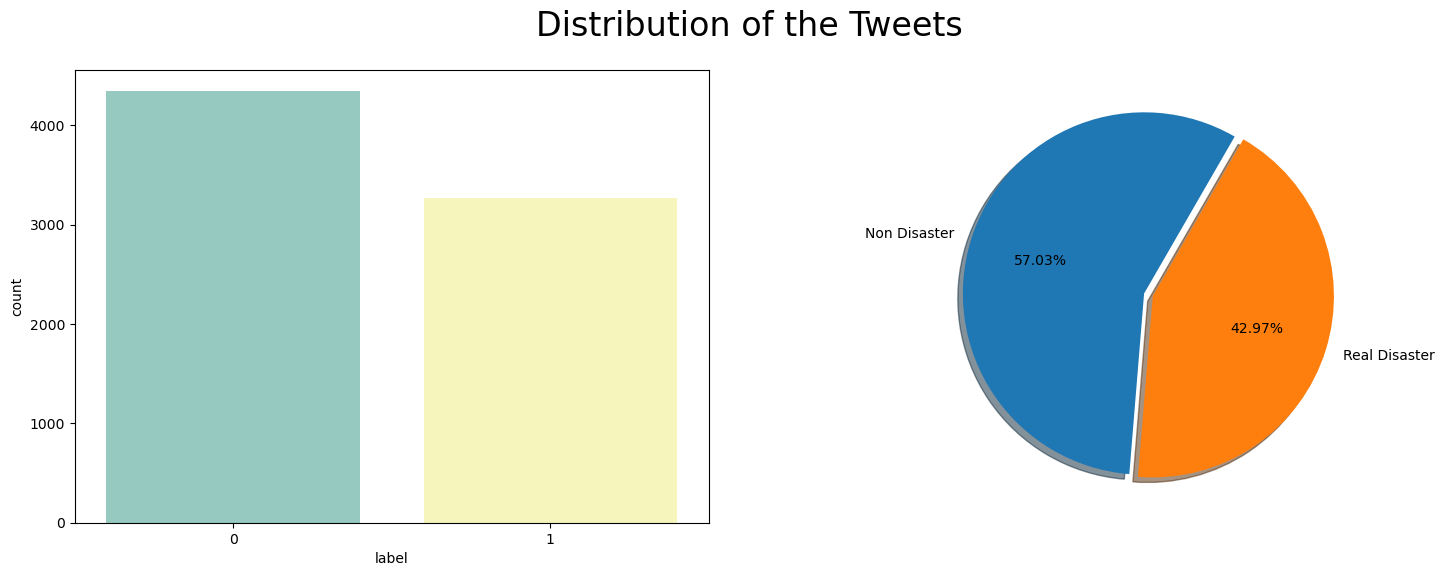

In [15]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), dpi=100)
sns.countplot(df['label'], ax=axes[0], palette="Set3")
axes[1].pie(df['label'].value_counts(),
            labels=['Non Disaster', 'Real Disaster'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Distribution of the Tweets', fontsize=24)
plt.show()

## b) Word Count

In [16]:
df['Word Count'] = df['sentence'].apply(lambda x: len(str(x).split()))

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches


def plot_dist_char(df, feature, title):
    # Creating a customized chart. and giving in figsize and everything.
    fig = plt.figure(constrained_layout=True, figsize=(20, 15))
    # Creating a grid of 3 cols and 3 rows.
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0, :2])
    # Set the title.
    ax1.set_title('Histogram')
    # plot the histogram.
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 color="b",rug=True)
    plt.axvline(df.loc[:, feature].mean(), linestyle="dashed",color="k", label='mean',linewidth=2)
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

    plt.title(f'{title}', fontsize=18)

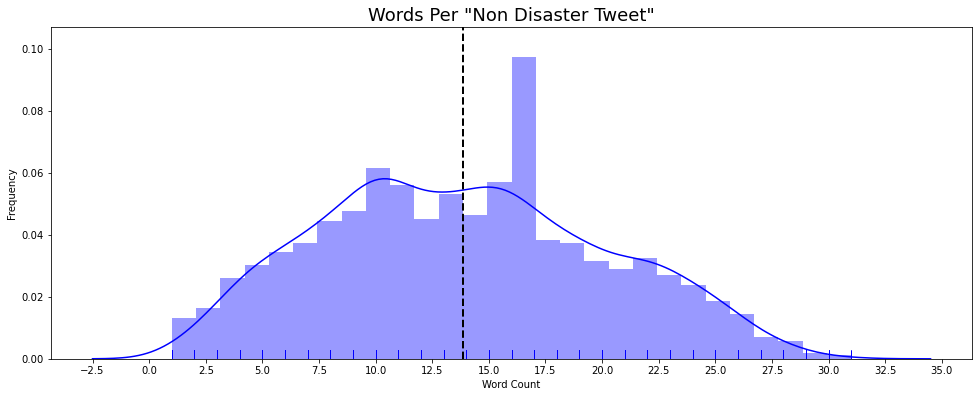

In [18]:
plot_dist_char(df[df['label'] == 0], 'Word Count', 'Words Per "Non Disaster Tweet"')

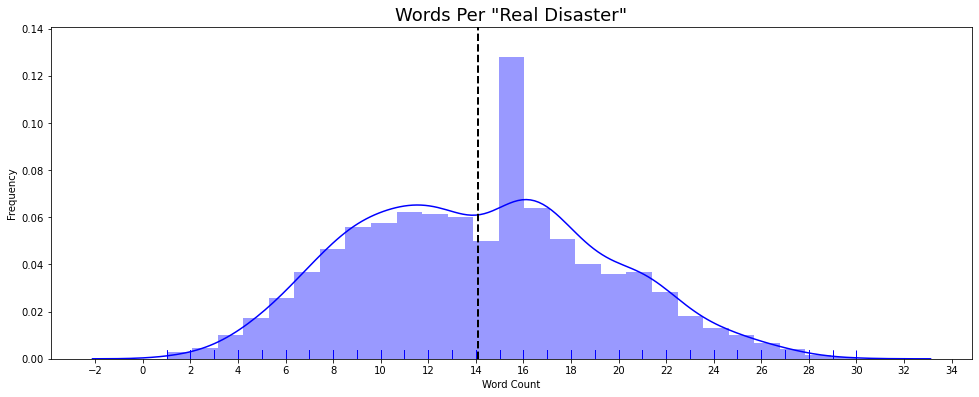

In [19]:
plot_dist_char(df[df['label'] == 1], 'Word Count', 'Words Per "Real Disaster"')

# Split the dataset for `training` and `testing`

We then split the dataset for training and testing.

In [20]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df)               # Default split ratio 75/25, we can modify using "test_size"
train.to_csv("dataset/train.csv", index=False)
test.to_csv("dataset/test.csv", index=False)

### Upload both to Amazon S3 for use later

The SageMaker Python SDK provides a helpful function for uploading to Amazon S3:

In [21]:
inputs_train = sagemaker_session.upload_data("dataset/train.csv", bucket=bucket, key_prefix=prefix)
inputs_test = sagemaker_session.upload_data("dataset/test.csv", bucket=bucket, key_prefix=prefix)

<a id = '5.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 5. Amazon SageMaker Training </h2>

## Amazon SageMaker

- When running a training job, SageMaker reads input data from Amazon S3, uses that data to train a model. 
- Training data from S3 is made available to the Model Training instance container, which is pulled from Amazon Elastic Container Registry(`ECR`). 
- The training job persists model artifacts back to the output S3 location designated in the training job configuration. 
- When we are ready to deploy a model, SageMaker spins up new ML instances and pulls in these model artifacts to use for batch or real-time model inference.

<img src = "img/sm-training.png" >

## Training script

We use the [PyTorch-Transformers library](https://pytorch.org/hub/huggingface_pytorch-transformers), which contains PyTorch implementations and pre-trained model weights for many NLP models, including BERT.

Our training script should save model artifacts learned during training to a file path called `model_dir`, as stipulated by the SageMaker PyTorch image. Upon completion of training, model artifacts saved in `model_dir` will be uploaded to S3 by SageMaker and will become available in S3 for deployment.

We save this script in a file named `train_deploy.py`, and put the file in a directory named `code/`. The full training script can be viewed under `code/`.

In [22]:
!pygmentize code/train_deploy.py

import argparse
import json
import logging
import os
import sys

import numpy as np
import pandas as pd
import torch
import torch.distributed as dist
import torch.utils.data
import torch.utils.data.distributed
from torch.utils.data import DataLoader, RandomSampler, TensorDataset
from transformers import AdamW, BertForSequenceClassification, BertTokenizer

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

MAX_LEN = 64  # this is the max length of the sentence

print("Loading BERT tokenizer...")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)


def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


def _get_train_data_loader(batch_size, training_dir):
    logger.info("Get train data loader")

    dataset = pd.read_csv(os.path.join(training_dir, "train.csv

<a id = '6.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 6. Train on Amazon SageMaker using on-demand instances with Epoch=2</h2>

We use Amazon SageMaker to train and deploy a model using our custom PyTorch code. The Amazon SageMaker Python SDK makes it easier to run a PyTorch script in Amazon SageMaker using its PyTorch estimator. After that, we can use the SageMaker Python SDK to deploy the trained model and run predictions. For more information on how to use this SDK with PyTorch, see [the SageMaker Python SDK documentation](https://sagemaker.readthedocs.io/en/stable/using_pytorch.html).

To start, we use the `PyTorch` estimator class to train our model. When creating our estimator, we make sure to specify a few things:

* `entry_point`: the name of our PyTorch script. It contains our training script, which loads data from the input channels, configures training with hyperparameters, trains a model, and saves a model. It also contains code to load and run the model during inference.
* `source_dir`: the location of our training scripts and requirements.txt file. "requirements.txt" lists packages you want to use with your script.
* `framework_version`: the PyTorch version we want to use

After creating the estimator, we then call fit(), which launches a training job. We use the Amazon S3 URIs where we uploaded the training data earlier.

<img src = "img/sm-estimator.png" >

In [24]:
from sagemaker.pytorch import PyTorch
from sagemaker.huggingface import HuggingFace

# 1. Defining the estimator 

estimator = PyTorch(entry_point="train_deploy.py",
                    source_dir="code",
                    role=role,
                    framework_version="1.9",
                    py_version="py38",
                    instance_count=1,
                    instance_type="ml.m5.xlarge",             # Type of instance we want the training to happen
                    hyperparameters={"epochs": 2,
                                     "num_labels": 2,
                                    }
                   )

# 2. Start the Training 

estimator.fit({"training": inputs_train, "testing": inputs_test})


2022-05-14 09:13:19 Starting - Starting the training job...
2022-05-14 09:13:42 Starting - Preparing the instances for trainingProfilerReport-1652519599: InProgress
......
2022-05-14 09:14:42 Downloading - Downloading input data...
2022-05-14 09:15:02 Training - Downloading the training image...
2022-05-14 09:15:50 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-05-14 09:15:52,084 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-05-14 09:15:52,086 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-05-14 09:15:52,097 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-05-14 09:15:52,106 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-05-14 09:15:52,498 sagemaker-training-toolkit INFO     Instal

<a id = '7.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 7. Train on Amazon SageMaker using spot instances </h2>

In [49]:
from sagemaker.pytorch import PyTorch
from sagemaker.huggingface import HuggingFace

# 1. Defining the estimator 

estimator = PyTorch(entry_point="train_deploy.py",
                    source_dir="code",
                    role=role,
                    framework_version="1.9",
                    py_version="py38",
                    instance_count=1,
                    instance_type="ml.m5.xlarge",             # Type of instance we want the training to happen
                    hyperparameters={"epochs": 2,
                                     "num_labels": 2,
                                    },
                    use_spot_instances=True,
                    max_run=4000,
                    max_wait=5000
                   )

# 2. Start the Training 

estimator.fit({"training": inputs_train, "testing": inputs_test})


2022-05-14 12:15:48 Starting - Starting the training job...
2022-05-14 12:15:49 Starting - Launching requested ML instancesProfilerReport-1652530547: InProgress
......
2022-05-14 12:17:14 Starting - Preparing the instances for training.........
2022-05-14 12:18:42 Downloading - Downloading input data...
2022-05-14 12:19:08 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-05-14 12:19:08,924 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-05-14 12:19:08,927 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-05-14 12:19:08,938 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-05-14 12:19:15,192 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-05-14 12:19:15,629 sagemaker-training-toolkit INFO     

<a id = '8.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 8. Host the model on an Amazon SageMaker Endpoint </h2>

After training our model, we host it on an Amazon SageMaker Endpoint. To make the endpoint load the model and serve predictions, we implement a few methods in `train_deploy.py`.

* `model_fn()`: function defined to load the saved model and return a model object that can be used for model serving. The SageMaker PyTorch model server loads our model by invoking model_fn.
* `input_fn()`: deserializes and prepares the prediction input. In this example, our request body is first serialized to JSON and then sent to model serving endpoint. Therefore, in `input_fn()`, we first deserialize the JSON-formatted request body and return the input as a `torch.tensor`, as required for BERT.
* `predict_fn()`: performs the prediction and returns the result.

To deploy our endpoint, we call `deploy()` on our PyTorch estimator object, passing in our desired number of instances and instance type:


In [25]:
predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

---------!

We then configure the predictor to use `application/json` for the content type when sending requests to our endpoint:

In [26]:
predictor.serializer = sagemaker.serializers.JSONSerializer()
predictor.deserializer = sagemaker.deserializers.JSONDeserializer()

# Prediction/Inferance

Finally, we use the returned predictor object to call the endpoint:

In [27]:
class_label = {1: "Real disaster",
               0: "Not a disaster"}

In [28]:
test_sentences = ["I met my friend today by accident",
                  "Frank had a severe head injury after the car accident last month", 
                  "Just happened a terrible car crash"
                  ]

In [29]:
result = predictor.predict(test_sentences)
result = list(np.argmax(result, axis=1))

predicted_labels = [class_label[l] for l in result]

In [30]:
predicted_labels

['Not a disaster', 'Real disaster', 'Real disaster']

In [31]:
for tweet, label in zip(test_sentences, predicted_labels):
    print(f"{tweet} ---> {label}")

I met my friend today by accident ---> Not a disaster
Frank had a severe head injury after the car accident last month ---> Real disaster
Just happened a terrible car crash ---> Real disaster


<a id = '9.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 9. Train on Amazon SageMaker using on-demand instances with Epoch=3 </h2>

In [ ]:
from sagemaker.pytorch import PyTorch
from sagemaker.huggingface import HuggingFace

# 1. Defining the estimator 

estimator = PyTorch(entry_point="train_deploy.py",
                    source_dir="code",
                    role=role,
                    framework_version="1.9",
                    py_version="py38",
                    instance_count=1,                         
                    instance_type="ml.m5.xlarge",             # Type of instance we want the training to happen
                    hyperparameters={"epochs": 3,
                                     "num_labels": 2
                                    }
                   )

# 2. Start the Training 

estimator.fit({"training": inputs_train, "testing": inputs_test})


2022-05-14 10:28:20 Starting - Starting the training job...
2022-05-14 10:28:46 Starting - Preparing the instances for trainingProfilerReport-1652524100: InProgress
......
2022-05-14 10:29:46 Downloading - Downloading input data...
2022-05-14 10:30:06 Training - Downloading the training image.....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-05-14 10:30:57,266 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-05-14 10:30:57,268 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-05-14 10:30:57,277 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-05-14 10:30:57,283 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-05-14 10:30:57,638 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/opt/conda/bin/python3.8 -m pip install -r requ

<a id = '10.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 10. Update a SageMaker model endpoint </h2>

As we know Machine Learning is a highly iterative process. During the course of a single project, data scientists and ML engineers routinely train thousands of different models in search of maximum accuracy. Indeed, the number of combinations for algorithms, data sets, and training parameters (aka hyperparameters) is infinite.

For example, let’s train a BERT model with updated hyperparameter (epoch = 3) value and see if model performance is improved or not.

If we find the improvement in model performance then we can update the existing SageMaker model endpoint.

In [34]:
model_path = 'model/'
code_path = 'code/'

In [35]:
!aws s3 cp {estimator.model_data} {model_path}

download: s3://sagemaker-us-east-2-920084877200/pytorch-training-2022-05-14-10-28-20-287/output/model.tar.gz to model/model.tar.gz


In [36]:
!tar -xvf {model_path}/model.tar.gz

model/
model/config.json
model/pytorch_model.bin


In [37]:
!rm {model_path}/model.tar.gz

In [38]:
!tar cvfz {model_path}/model.tar.gz {model_path} {code_path}

model/
model/config.json
model/pytorch_model.bin
tar: model: file changed as we read it
code/
code/.ipynb_checkpoints/
code/.ipynb_checkpoints/train_deploy-checkpoint.py
code/train_deploy.py
code/requirements.txt


In [39]:
!aws s3 cp {model_path}/model.tar.gz {estimator.model_data}

upload: model/model.tar.gz to s3://sagemaker-us-east-2-920084877200/pytorch-training-2022-05-14-10-28-20-287/output/model.tar.gz


In [40]:
import boto3
import tarfile
import os

sm_client = boto3.client('sagemaker')

image_uri = sagemaker.image_uris.retrieve(
    framework="pytorch",
    region=region,
    py_version="py38",
    image_scope="inference",
    version="1.9",
    instance_type="ml.m4.xlarge",
)

primary_container = {
    'Image': image_uri,
    'ModelDataUrl': estimator.model_data,
    'Environment': {
        'SAGEMAKER_PROGRAM': 'train_deploy.py',
        'SAGEMAKER_REGION': region,
        'SAGEMAKER_SUBMIT_DIRECTORY': estimator.model_data
    }
}

In [41]:
model_name = estimator.model_data.split('/')[-3]
model_name

'pytorch-training-2022-05-14-10-28-20-287'

In [42]:
create_model_response = sm_client.create_model(
   ModelName = model_name, ExecutionRoleArn = role, PrimaryContainer = primary_container
)

In [43]:
predictor.update_endpoint(initial_instance_count=1, instance_type="ml.m4.xlarge", model_name=model_name)

--------!

# Prediction/Inferance

In [44]:
class_label = {1: "Real disaster",
               0: "Not a disaster"}

In [45]:
test_sentences = ["I met my friend today by accident",
                  "Frank had a severe head injury after the car accident last month", 
                  "Just happened a terrible car crash"
                  ]

In [46]:
result = predictor.predict(test_sentences)
result = list(np.argmax(result, axis=1))

predicted_labels = [class_label[l] for l in result]

In [47]:
predicted_labels

['Not a disaster', 'Real disaster', 'Real disaster']

In [48]:
for tweet, label in zip(test_sentences, predicted_labels):
    print(f"{tweet} ---> {label}")

I met my friend today by accident ---> Not a disaster
Frank had a severe head injury after the car accident last month ---> Real disaster
Just happened a terrible car crash ---> Real disaster


Before moving on, let's delete the Amazon SageMaker endpoint to avoid charges:

<a id = '11.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 11. Clean up </h2>

Lastly, please remember to delete the Amazon SageMaker endpoint to avoid charges:

In [50]:
predictor.delete_endpoint()

<a id = '12.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 12. Conclusion </h2>

- Hopefully this post will help you leverage the power of Amazon SageMaker to train, deploy and update a HuggingFace BERT models on your own data using Amazon in-built Deep learning containers.

- Amazon SageMaker abstracts away the complexities related to maintaining secure and expensive GPU-powered virtual machines for training phase and also simplifies the process of deploying the model to production.

- We went through Amazon SageMaker training process, understood how we can train a model using on-demand instances and spot instances.
Model training using spot instances can save the cost of training models up to 90% over on-demand instances.

- As we know Machine Learning is a highly iterative process. How one can update the hyperparameters and update a SageMaker model endpoint when there is an improvement on model performance.

- Finally we have to clean up SageMaker endpoint to avoid charges.

I would love to hear your suggestions on further improvements and also welcome your code contribution to the [github repo](https://github.com/Vinayaks117/AWS-SageMaker-Examples.git)

<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> References </h2>

- [Introduction to Transformers and BERT on Amazon SageMaker](https://www.youtube.com/watch?v=D9Qo5OpG4p8)
- [Use PyTorch with the SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html)
- [Prebuilt SageMaker Docker Images for Deep Learning](https://docs.aws.amazon.com/sagemaker/latest/dg/pre-built-containers-frameworks-deep-learning.html)
- [Use Checkpoints in Amazon SageMaker](https://docs.aws.amazon.com/sagemaker/latest/dg/model-checkpoints.html)
- [Managed Spot Training in Amazon SageMaker](https://docs.aws.amazon.com/sagemaker/latest/dg/model-managed-spot-training.html)